<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [2]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.35MB/s]


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # start tensors: 28x28x1
        # Convolutional layer 1: in_channels=1, out_channels=6, kernel_size=5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #tensor after: 28x28x6

        # Subsampling layer 1: 2x2 average pooling
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 14x14x6

        # Convolutional layer 2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #tensor after: 10x10x16

        # Subsampling layer 2: 2x2 average pooling
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input from previous feature map
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))   # Conv1 + Tanh
        x = self.pool1(x)           # Pool1
        x = torch.sigmoid(self.conv2(x))   # Conv2 + Tanh
        x = self.pool2(x)           # Pool2
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = torch.sigmoid(self.fc1(x))     # FC1 + Tanh
        x = torch.sigmoid(self.fc2(x))     # FC2 + Tanh
        x = self.fc3(x)             # Output layer (logits)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(4):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cpu
epoch: 0 batch: 0 current batch loss: 2.3329474925994873
epoch: 0 batch: 1 current batch loss: 2.321423053741455
epoch: 0 batch: 2 current batch loss: 2.3179569244384766
epoch: 0 batch: 3 current batch loss: 2.306425094604492
epoch: 0 batch: 4 current batch loss: 2.302381753921509
epoch: 0 batch: 5 current batch loss: 2.3045833110809326
epoch: 0 batch: 6 current batch loss: 2.301459312438965
epoch: 0 batch: 7 current batch loss: 2.307189702987671
epoch: 0 batch: 8 current batch loss: 2.3045761585235596
epoch: 0 batch: 9 current batch loss: 2.3023295402526855
epoch: 0 batch: 10 current batch loss: 2.310544490814209
epoch: 0 batch: 11 current batch loss: 2.306178092956543
epoch: 0 batch: 12 current batch loss: 2.304105281829834
epoch: 0 batch: 13 current batch loss: 2.307429313659668
epoch: 0 batch: 14 current batch loss: 2.30637526512146
epoch: 0 batch: 15 current batch loss: 2.301459550857544
epoch: 0 batch: 16 current batch loss: 2.3070895671844482
epoch: 0 batch: 17 cu

# Testing
----------------------

In [6]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.6841


In [7]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def dream_digits_l2(model, num_steps=600, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 kara (kwadraty wart. pixeli)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

cpu


Step 0 | CE Loss: 3.2845 | L2: 1.0181 | Mean Conf: 0.0463
Step 50 | CE Loss: 0.9444 | L2: 1.6244 | Mean Conf: 0.4175
Step 100 | CE Loss: 0.9333 | L2: 1.4008 | Mean Conf: 0.4223
Step 150 | CE Loss: 0.9294 | L2: 1.2004 | Mean Conf: 0.4240
Step 200 | CE Loss: 0.9275 | L2: 1.0496 | Mean Conf: 0.4248
Step 250 | CE Loss: 0.9266 | L2: 0.9354 | Mean Conf: 0.4252
Step 300 | CE Loss: 0.9261 | L2: 0.8502 | Mean Conf: 0.4254
Step 350 | CE Loss: 0.9259 | L2: 0.7864 | Mean Conf: 0.4255
Step 400 | CE Loss: 0.9257 | L2: 0.7377 | Mean Conf: 0.4256
Step 450 | CE Loss: 0.9255 | L2: 0.6998 | Mean Conf: 0.4256
Step 500 | CE Loss: 0.9254 | L2: 0.6697 | Mean Conf: 0.4257
Step 550 | CE Loss: 0.9253 | L2: 0.6456 | Mean Conf: 0.4257
Step 599 | CE Loss: 0.9253 | L2: 0.6262 | Mean Conf: 0.4257


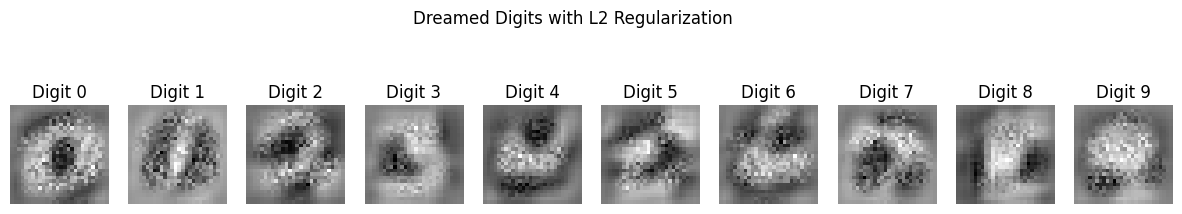

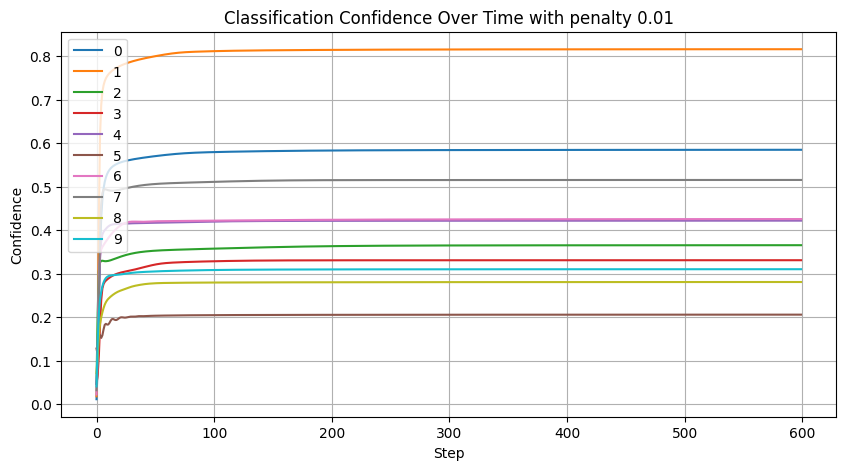

Step 0 | CE Loss: 2.4070 | L2: 0.9850 | Mean Conf: 0.1134
Step 50 | CE Loss: 0.9369 | L2: 0.6688 | Mean Conf: 0.4212
Step 100 | CE Loss: 0.9357 | L2: 0.3439 | Mean Conf: 0.4217
Step 150 | CE Loss: 0.9364 | L2: 0.2360 | Mean Conf: 0.4214
Step 200 | CE Loss: 0.9366 | L2: 0.1946 | Mean Conf: 0.4213
Step 250 | CE Loss: 0.9366 | L2: 0.1768 | Mean Conf: 0.4212
Step 300 | CE Loss: 0.9366 | L2: 0.1687 | Mean Conf: 0.4212
Step 350 | CE Loss: 0.9366 | L2: 0.1648 | Mean Conf: 0.4212
Step 400 | CE Loss: 0.9366 | L2: 0.1630 | Mean Conf: 0.4212
Step 450 | CE Loss: 0.9366 | L2: 0.1621 | Mean Conf: 0.4212
Step 500 | CE Loss: 0.9366 | L2: 0.1616 | Mean Conf: 0.4212
Step 550 | CE Loss: 0.9366 | L2: 0.1614 | Mean Conf: 0.4212
Step 599 | CE Loss: 0.9366 | L2: 0.1613 | Mean Conf: 0.4212


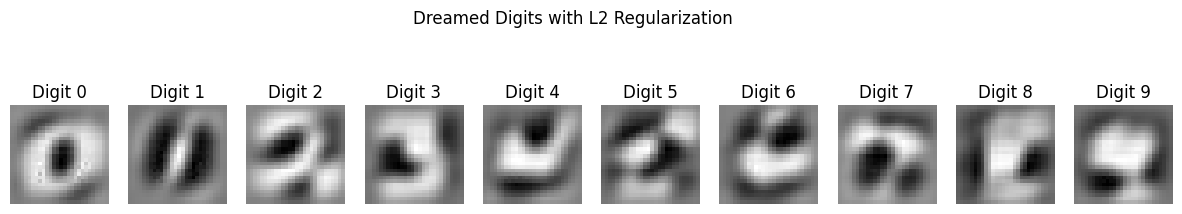

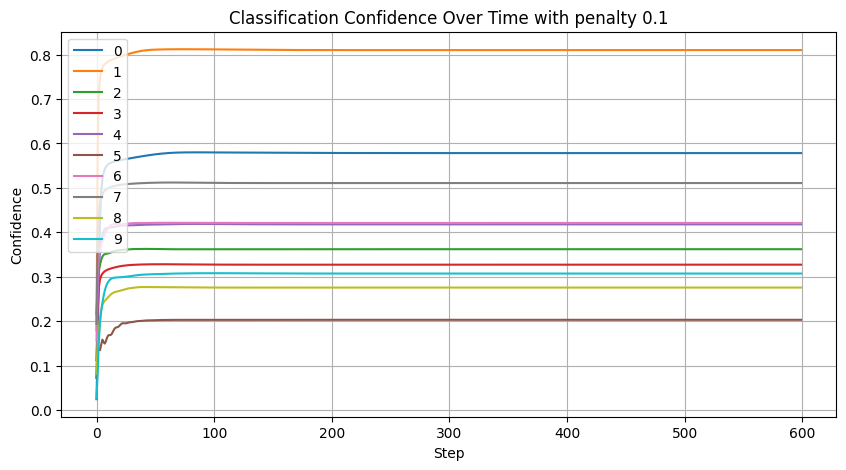

Step 0 | CE Loss: 2.9595 | L2: 0.9842 | Mean Conf: 0.0746
Step 50 | CE Loss: 0.9725 | L2: 0.0801 | Mean Conf: 0.4081
Step 100 | CE Loss: 0.9723 | L2: 0.0484 | Mean Conf: 0.4074
Step 150 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 200 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 250 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 300 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 350 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 400 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 450 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 500 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074
Step 550 | CE Loss: 0.9722 | L2: 0.0477 | Mean Conf: 0.4074
Step 599 | CE Loss: 0.9721 | L2: 0.0477 | Mean Conf: 0.4074


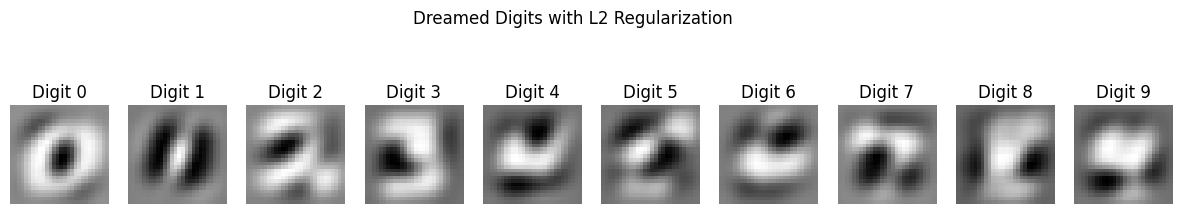

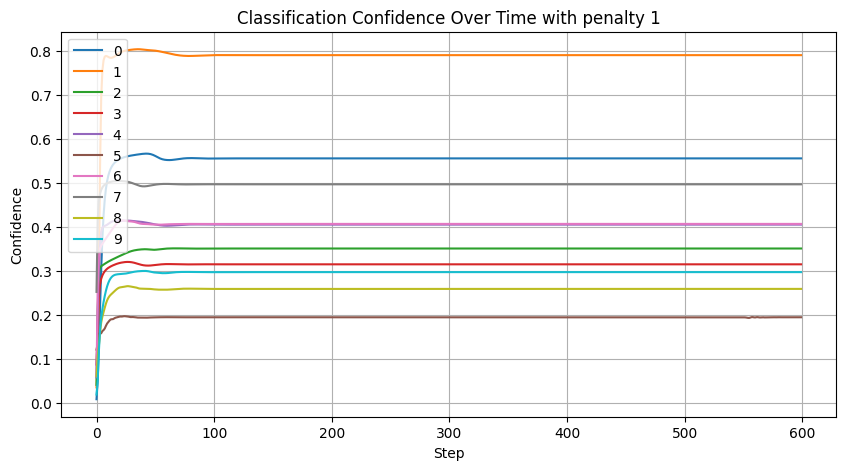

Step 0 | CE Loss: 2.4420 | L2: 0.9791 | Mean Conf: 0.1061
Step 50 | CE Loss: 1.0809 | L2: 0.0159 | Mean Conf: 0.3674
Step 100 | CE Loss: 1.0812 | L2: 0.0133 | Mean Conf: 0.3673
Step 150 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 200 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 250 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 300 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 350 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 400 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 450 | CE Loss: 1.0812 | L2: 0.0133 | Mean Conf: 0.3674
Step 500 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 550 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674
Step 599 | CE Loss: 1.0811 | L2: 0.0133 | Mean Conf: 0.3674


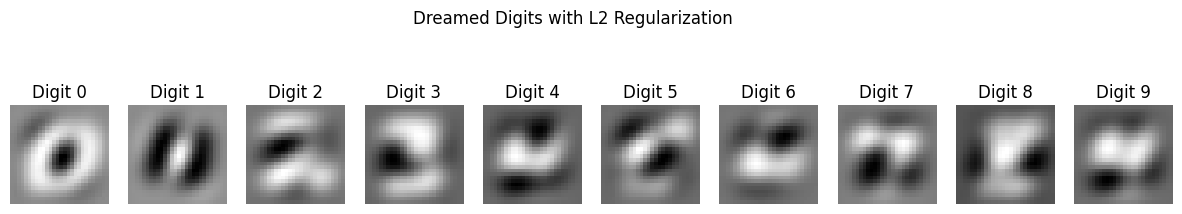

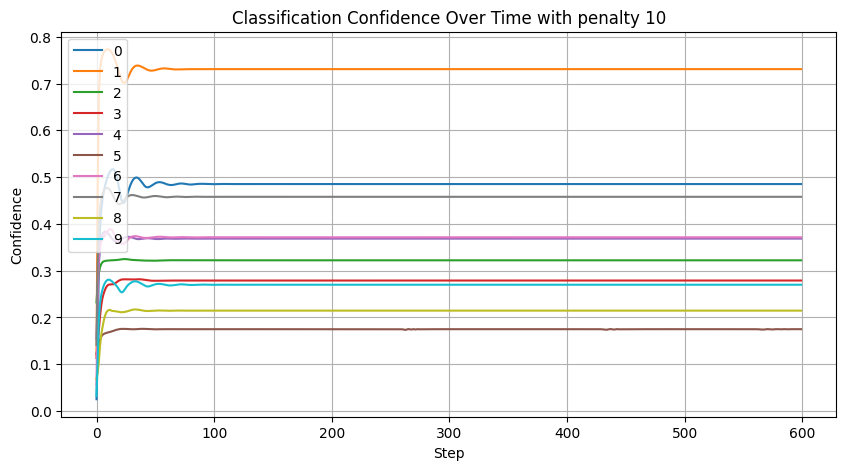

Step 0 | CE Loss: 2.8295 | L2: 1.0116 | Mean Conf: 0.0690
Step 50 | CE Loss: 1.4141 | L2: 0.0050 | Mean Conf: 0.2650
Step 100 | CE Loss: 1.4135 | L2: 0.0025 | Mean Conf: 0.2651
Step 150 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 200 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 250 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 300 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 350 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 400 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 450 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 500 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 550 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651
Step 599 | CE Loss: 1.4134 | L2: 0.0025 | Mean Conf: 0.2651


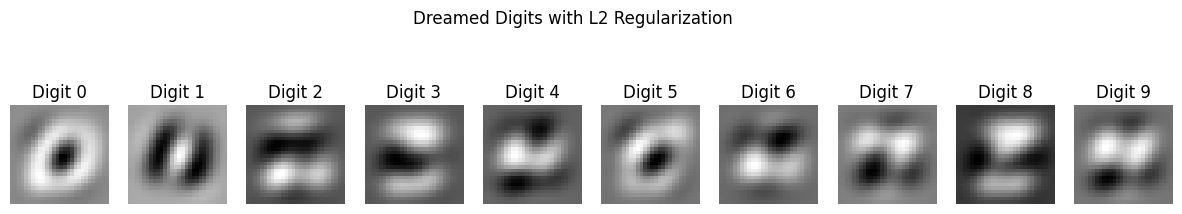

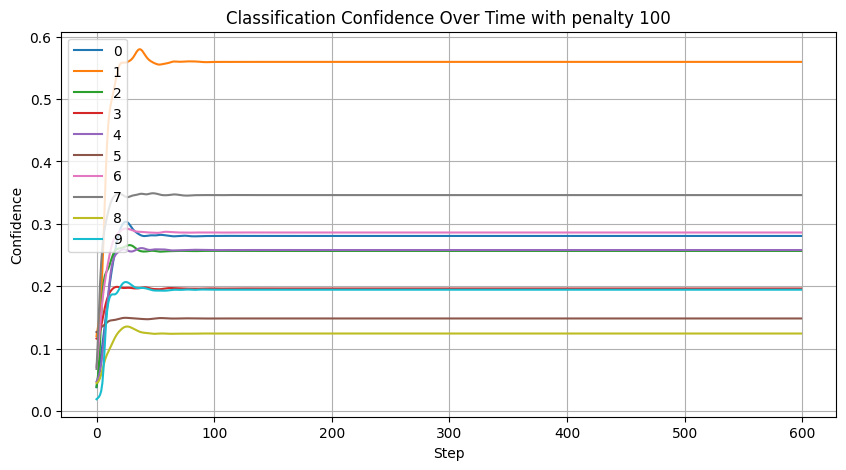

In [8]:
def plot_task3_results(images, history, lambda_l2):

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()


    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()
    # test dla różnych kar.
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(net, lambda_l2=lam)

  plot_task3_results(final_images, confidence_history, lam)

# Adwersaryjna część

In [19]:
def generate_adversarial_example(x, y_wrong, model, lambda_l2=0.01, num_steps=40, lr=0.01):

    x = x.clone().detach()
    x = x.to(device)

    delta = torch.zeros_like(x, requires_grad=True).to(device)

    # Choose a wrong target class
    y_wrong_tensor = torch.tensor([y_wrong], device=device)
    #print(y_wrong_tensor.dim())
    optimizer = torch.optim.Adam([delta], lr=lr)
    #print(x.dtype, y_wrong.dtype)
    history = []
    for _ in range(num_steps):
        optimizer.zero_grad()

        output = model(x + delta)
        loss = F.cross_entropy(output, y_wrong_tensor) + lambda_l2 * delta.pow(2).mean()

        loss.backward()
        optimizer.step()


        # Optional: clamp to [0, 1] valid pixel range
        delta.data = torch.clamp(x + delta.data, 0, 1) - x
        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            #print(x.dtype, y.dtype)
            confidence = probs[0, torch.arange(10)].detach().cpu().numpy()
            history.append(confidence)

    x_adv = x + delta.detach()
    return x_adv, y_wrong, history

In [10]:
def show_images(original, adversarial, orig_pred, adv_pred):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title(f'Original (Pred: {orig_pred})')
    axs[1].imshow(adversarial.squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial (Pred: {adv_pred})')
    for ax in axs:
        ax.axis('off')
    #plt.suptitle(f'Example {i}')
    plt.show()

In [11]:
# just history plots
def pl_hist(history, lambda_l2, true_label):
    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()

In [12]:
def plot_confidence_history(conf_history, lambda_l2, y_true, y_wrong):
    plt.figure(figsize=(6, 4))
    plt.plot(conf_history, label=[i for i in range(10)])
    plt.title(f"Confidence in Target Class {y_wrong} (True={y_true})\nLambda={lambda_l2}")
    plt.xlabel("Attack Step")
    plt.ylabel("Confidence in Target Class")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [39]:
lambda_l2 = 1
def adversarial_on_testset(lambda_l2):
  success_counts= [[0 for i in range(10)] for j in range(10)]
  trials_counts= [[0 for i in range(10)] for j in range(10)]
  j= 0
  for i, (x, y) in enumerate(testloader):
      print(i)
      if i >= 80:
        break
      y_true = y.item()
      x = x.to(device)
      y = y.to(device)

      if net(x).argmax(dim=1).item() != y_true:
          continue
      for y_wrong in range(10):
          if y_wrong == y_true:
              continue

          trials_counts[y_true][y_wrong] +=1
          # Run adversarial generation
          x_adv, _, conf_hist = generate_adversarial_example(x, y_wrong, net, lambda_l2=lambda_l2)

          with torch.no_grad():
              adv_pred = net(x_adv).argmax(dim=1).item()

          if adv_pred == y_wrong:
              success_counts[y_true][y_wrong]+=1

              if success_counts[y_true] [y_wrong] == 1:

                print(f"Found adversarial example for True={y_true}, Target={y_wrong}")
                show_images(x.squeeze().detach().cpu().numpy(), x_adv.squeeze().detach().cpu().numpy(), y_true, y_wrong)
                j+=1
                if j % 5 == 0:
                  plot_confidence_history(conf_hist, lambda_l2, y_true, y_wrong)

  success_counts, trials_counts = np.array(success_counts), np.array(trials_counts)
  return success_counts, trials_counts
              # Optional: Save or show the imaget



0
Found adversarial example for True=7, Target=0


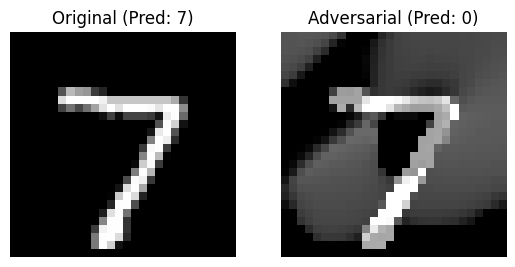

Found adversarial example for True=7, Target=2


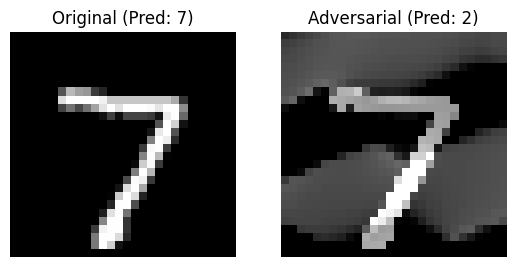

Found adversarial example for True=7, Target=3


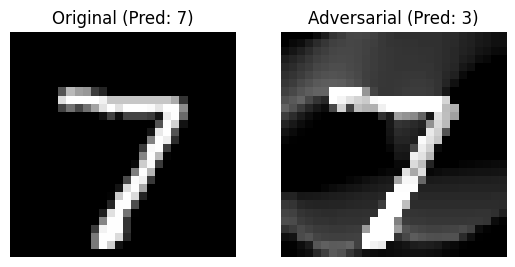

Found adversarial example for True=7, Target=9


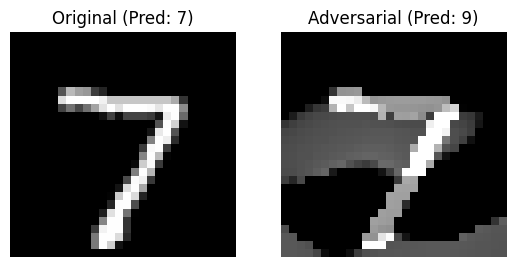

1
Found adversarial example for True=2, Target=0


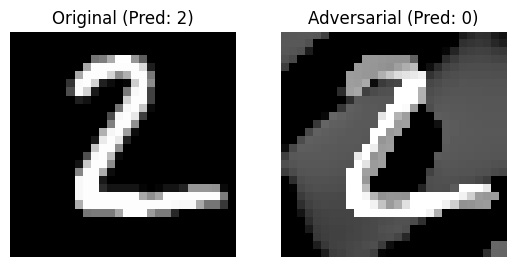

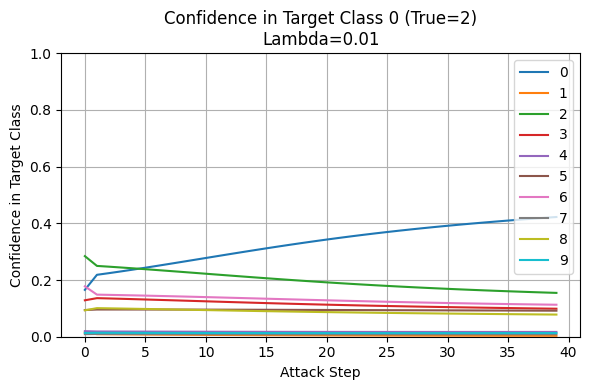

Found adversarial example for True=2, Target=3


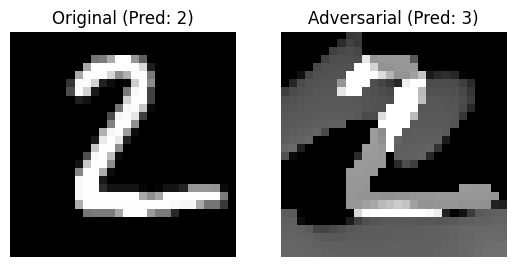

2
Found adversarial example for True=1, Target=0


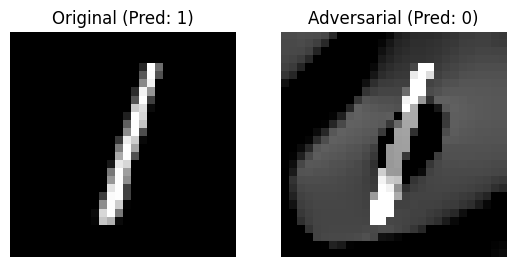

Found adversarial example for True=1, Target=2


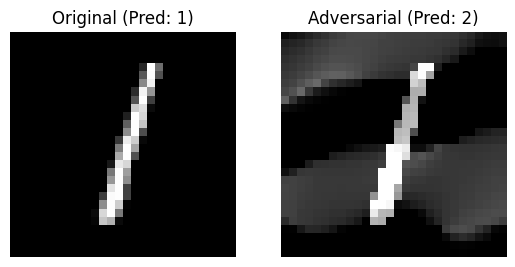

Found adversarial example for True=1, Target=3


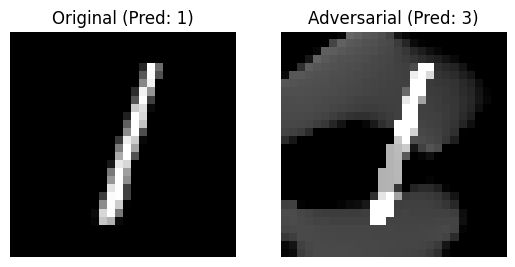

Found adversarial example for True=1, Target=4


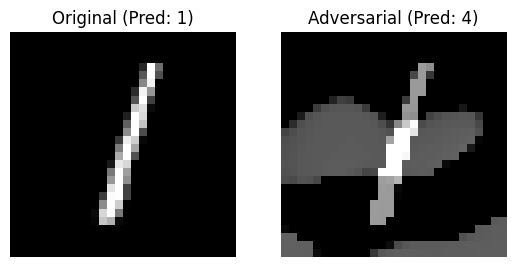

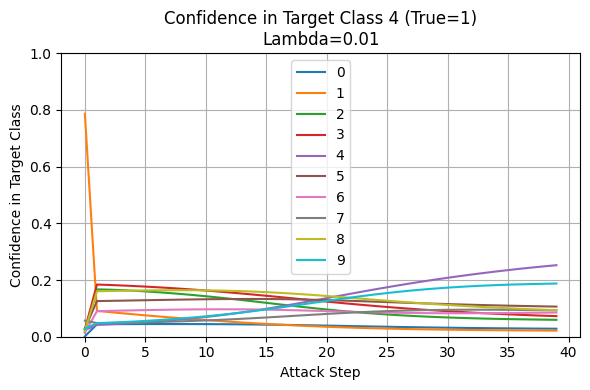

Found adversarial example for True=1, Target=6


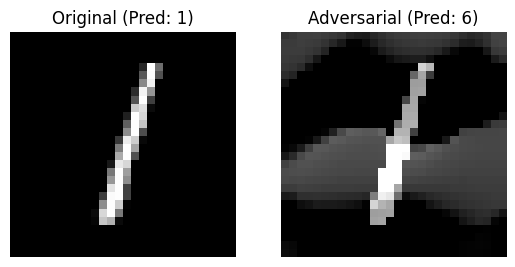

Found adversarial example for True=1, Target=7


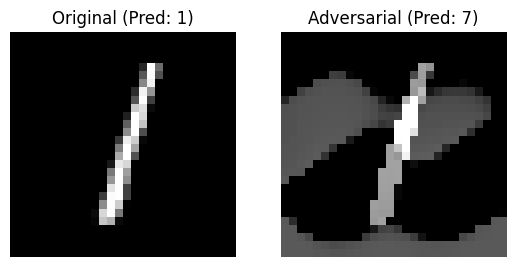

Found adversarial example for True=1, Target=9


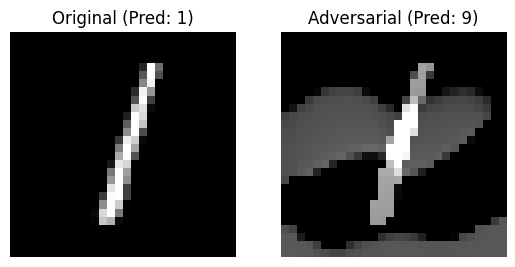

3
Found adversarial example for True=0, Target=3


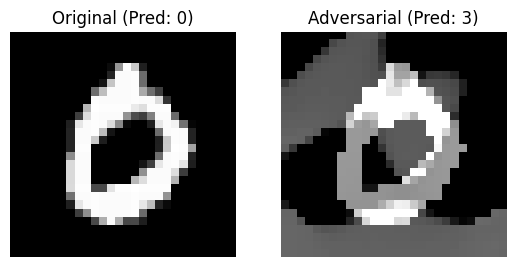

4
Found adversarial example for True=4, Target=0


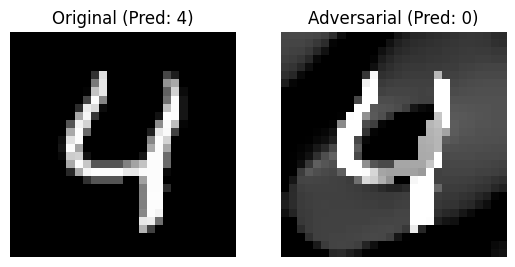

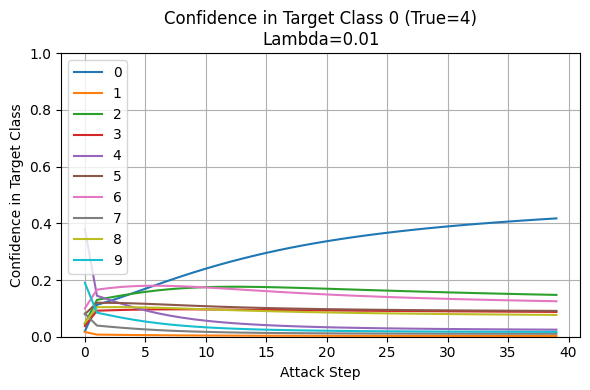

Found adversarial example for True=4, Target=2


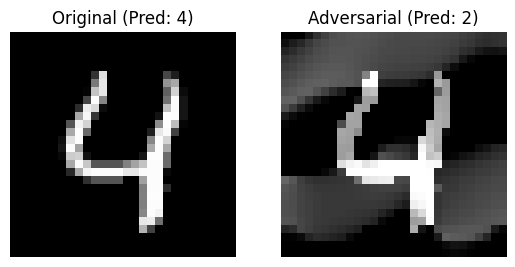

Found adversarial example for True=4, Target=3


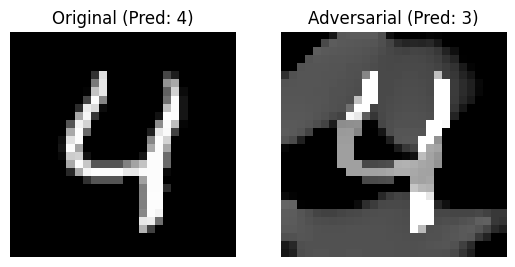

Found adversarial example for True=4, Target=6


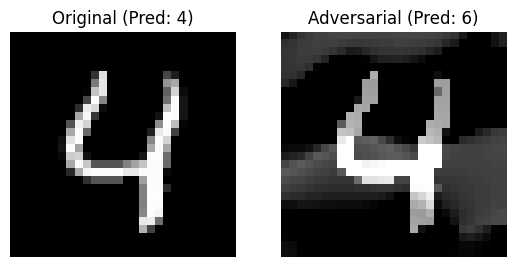

Found adversarial example for True=4, Target=9


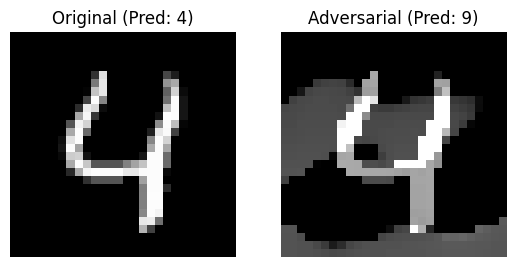

5
Found adversarial example for True=1, Target=8


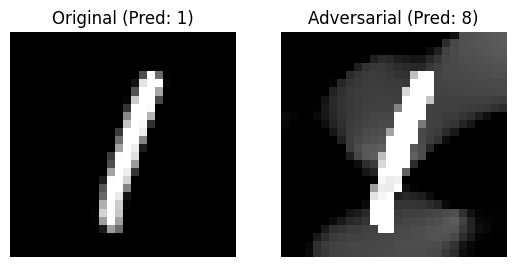

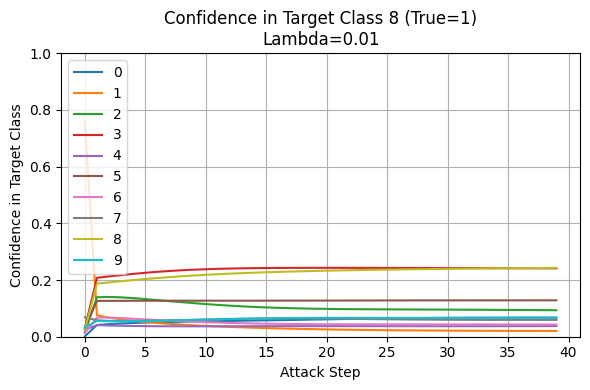

6
7
8
9
Found adversarial example for True=9, Target=0


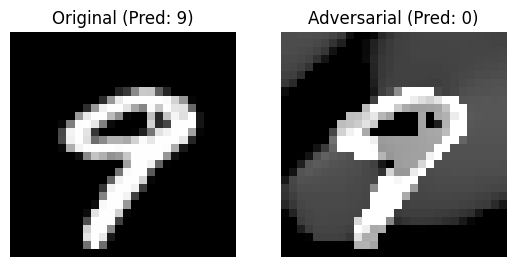

Found adversarial example for True=9, Target=3


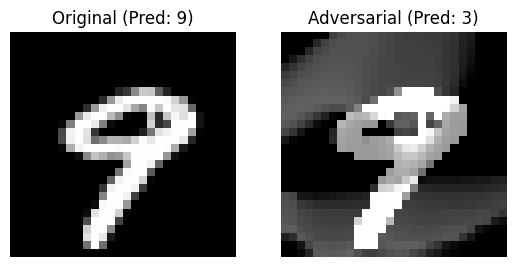

Found adversarial example for True=9, Target=4


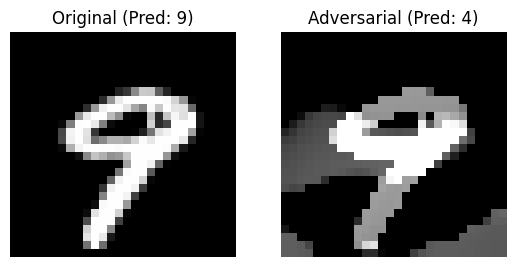

Found adversarial example for True=9, Target=7


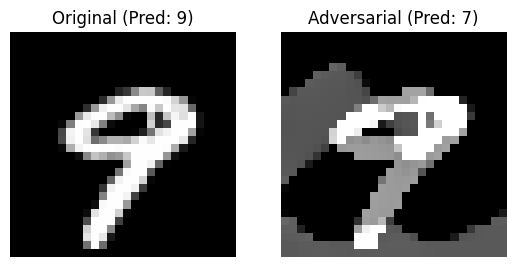

10


In [37]:
suc_cnt_1, trial_cnt_1 = adversarial_on_testset(0.01)

In [38]:
trial_cnt_1

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 0, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

<ipython-input-23-4d0b85d718a5>:2: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_1/trial_cnt_1


<Axes: >

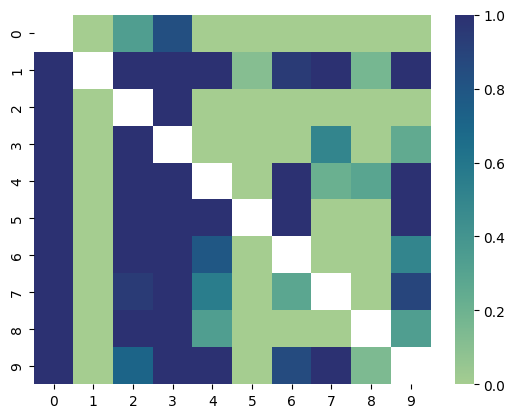

In [23]:
import seaborn as sns
rates = suc_cnt_1/trial_cnt_1
sns.heatmap(rates,cmap="crest")

0
Found adversarial example for True=7, Target=0


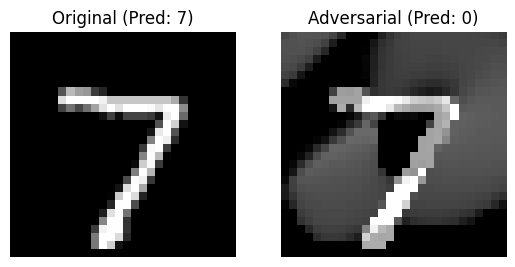

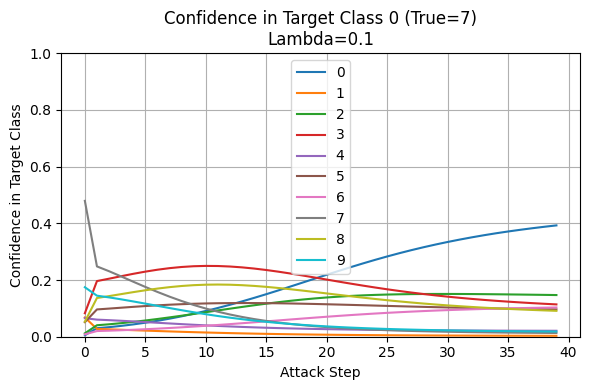

Found adversarial example for True=7, Target=2


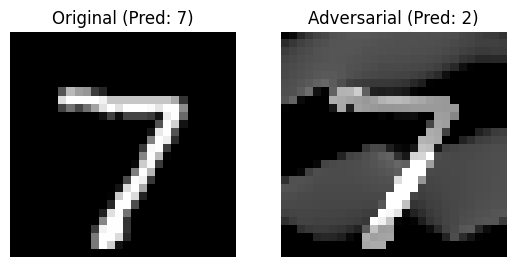

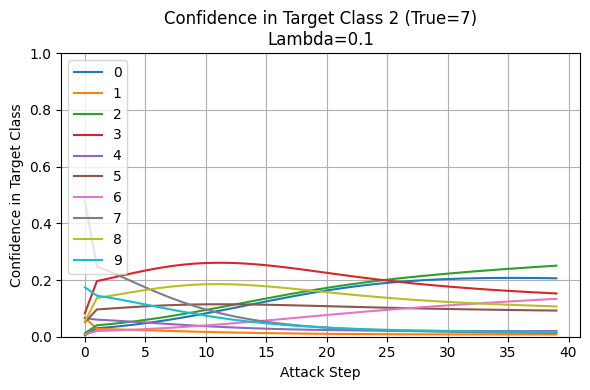

Found adversarial example for True=7, Target=3


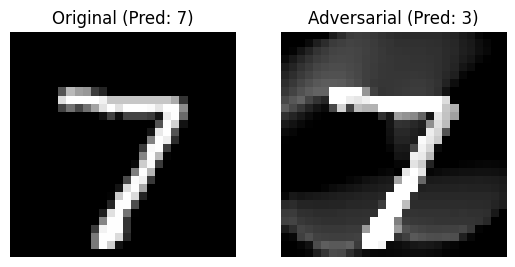

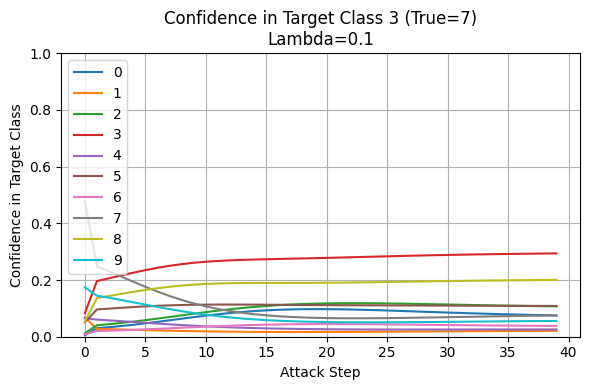

Found adversarial example for True=7, Target=9


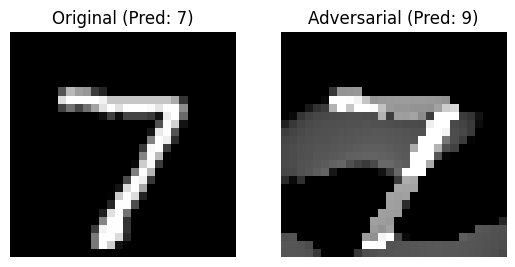

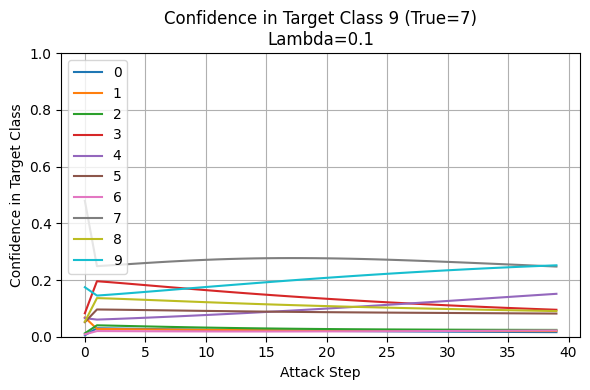

1
Found adversarial example for True=2, Target=0


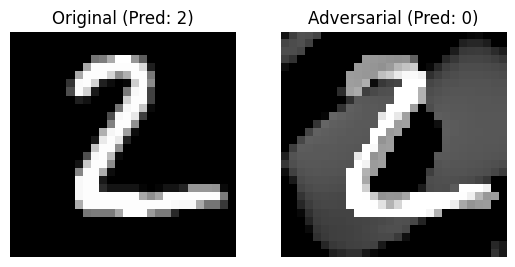

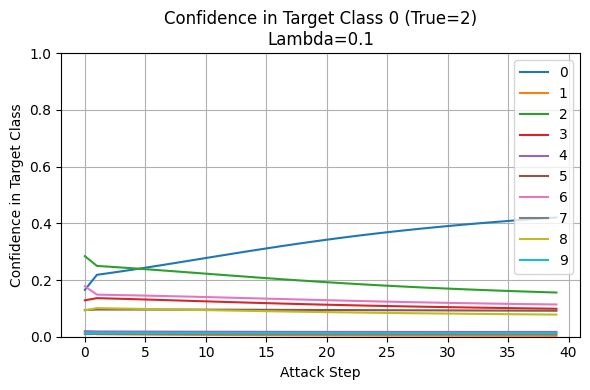

Found adversarial example for True=2, Target=3


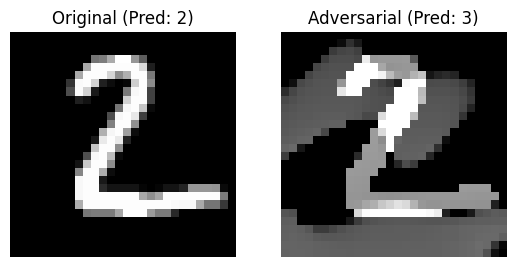

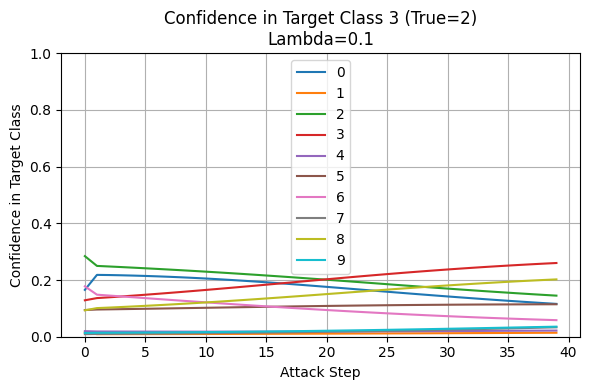

2
Found adversarial example for True=1, Target=0


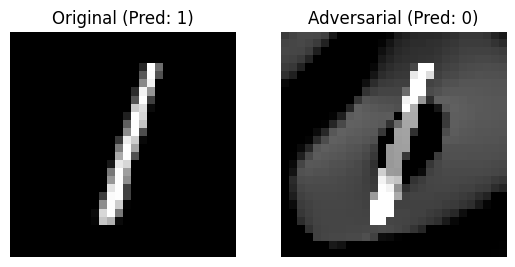

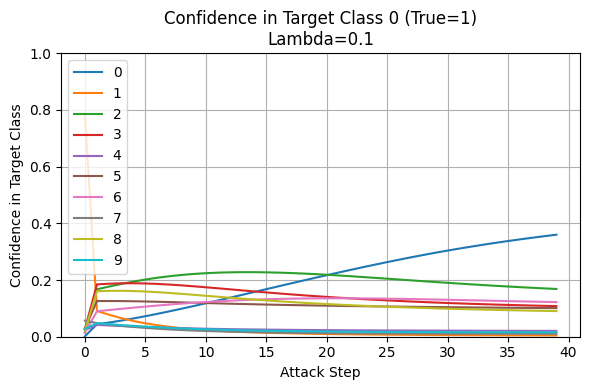

Found adversarial example for True=1, Target=2


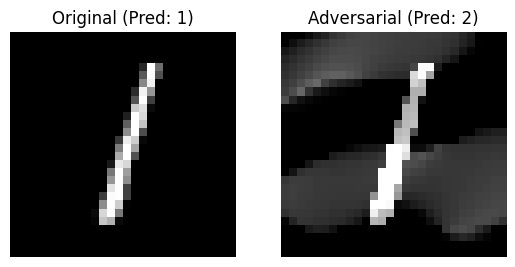

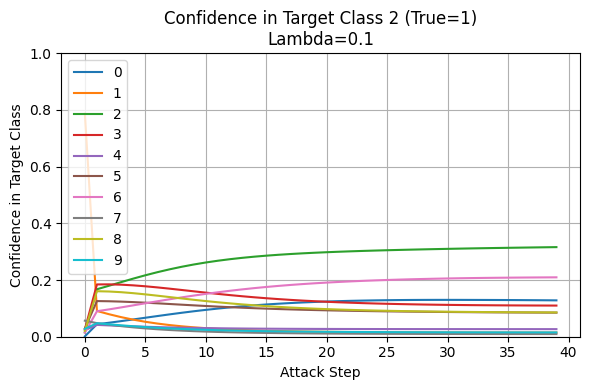

Found adversarial example for True=1, Target=3


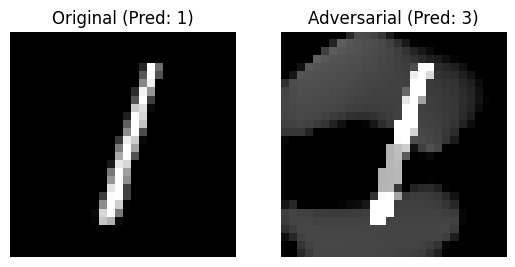

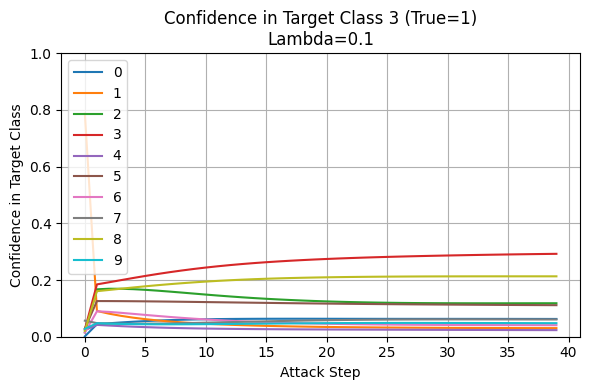

Found adversarial example for True=1, Target=4


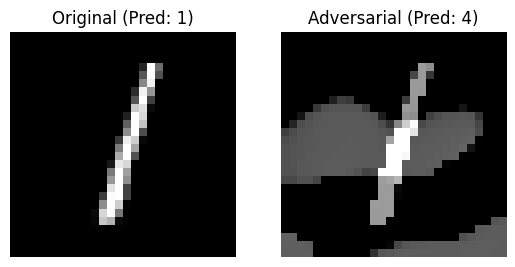

Found adversarial example for True=1, Target=6


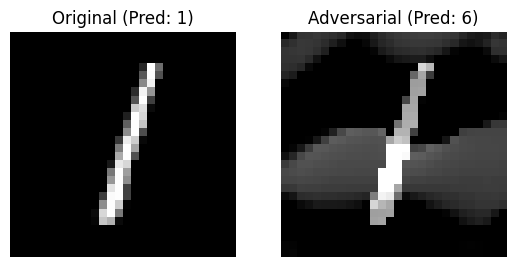

Found adversarial example for True=1, Target=7


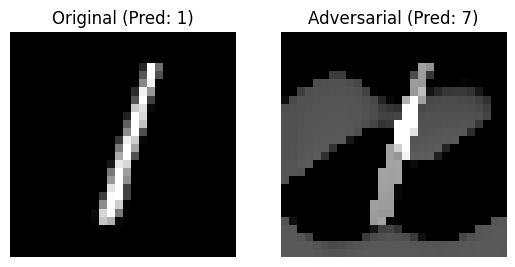

Found adversarial example for True=1, Target=9


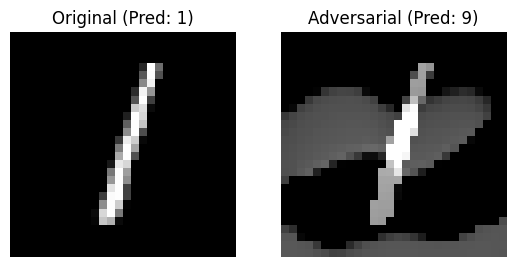

3
Found adversarial example for True=0, Target=3


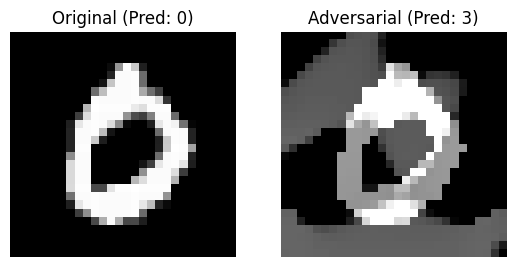

4
Found adversarial example for True=4, Target=0


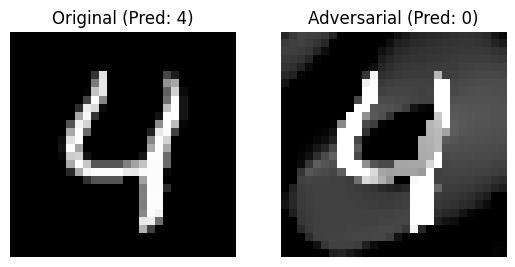

Found adversarial example for True=4, Target=2


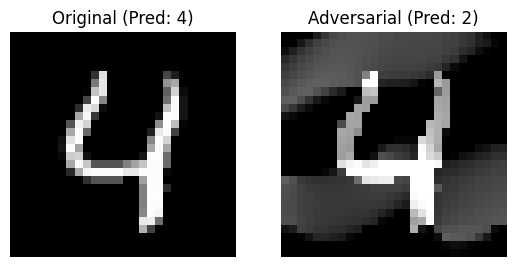

Found adversarial example for True=4, Target=3


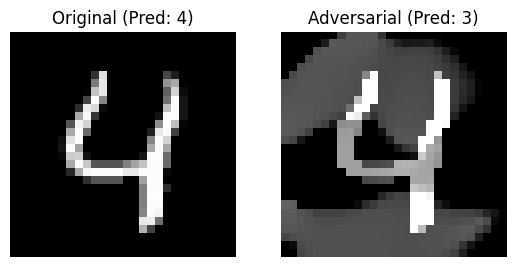

Found adversarial example for True=4, Target=6


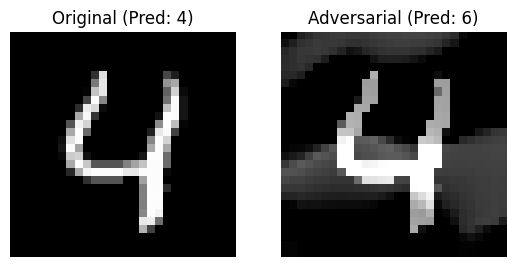

Found adversarial example for True=4, Target=9


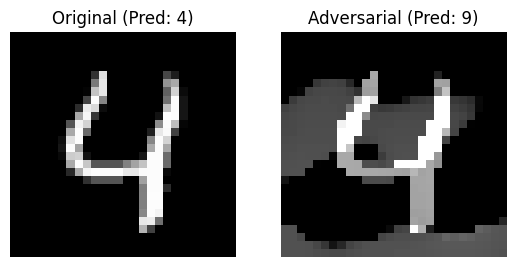

5
Found adversarial example for True=1, Target=8


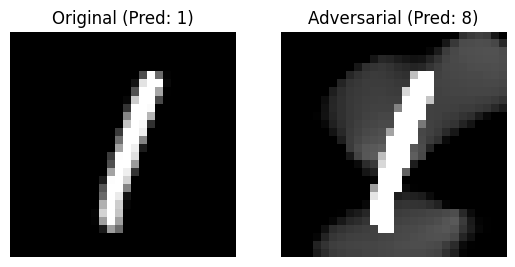

6
7
8
9
Found adversarial example for True=9, Target=0


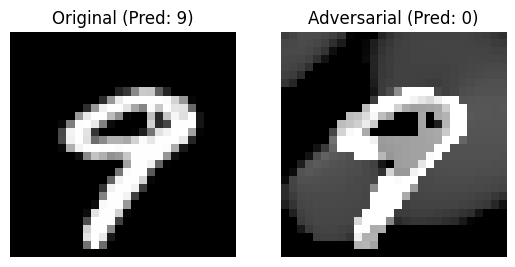

Found adversarial example for True=9, Target=3


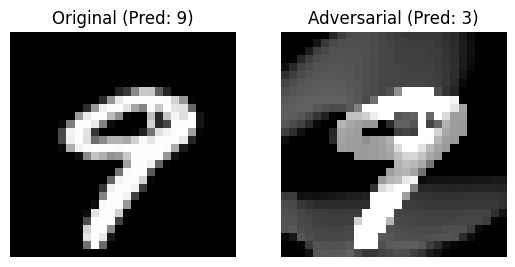

Found adversarial example for True=9, Target=4


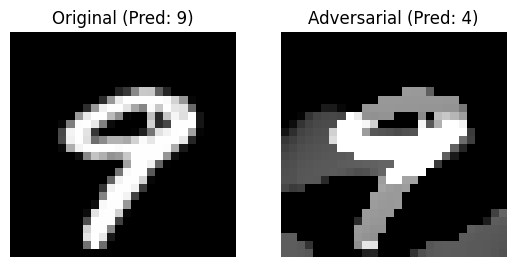

Found adversarial example for True=9, Target=7


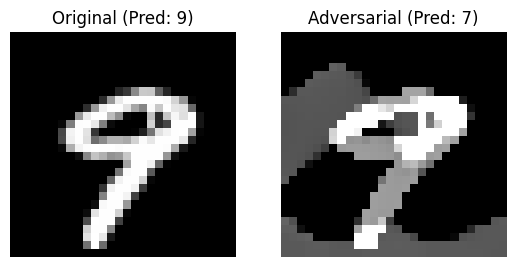

10
11
Found adversarial example for True=6, Target=0


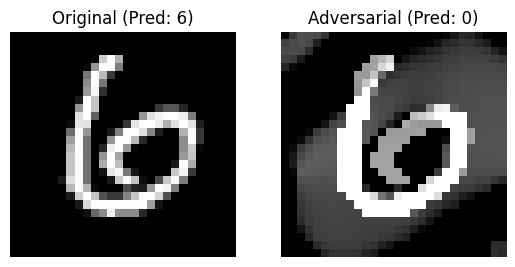

Found adversarial example for True=6, Target=2


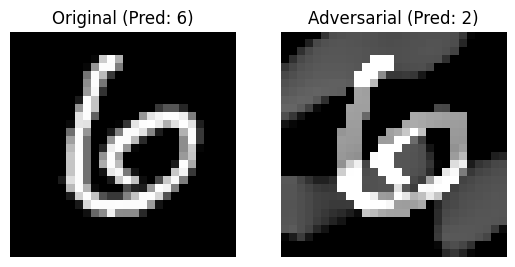

Found adversarial example for True=6, Target=3


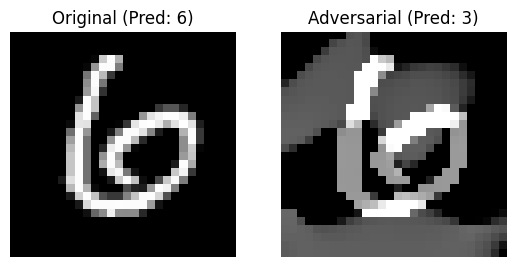

Found adversarial example for True=6, Target=4


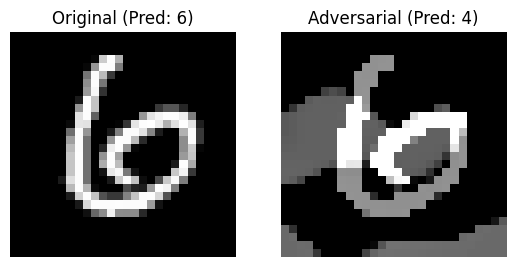

12
Found adversarial example for True=9, Target=2


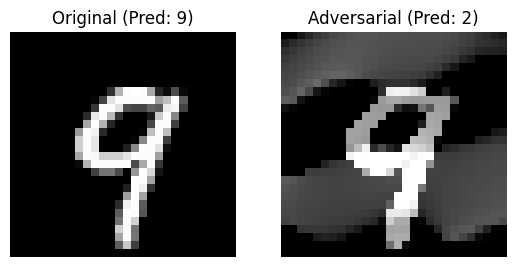

Found adversarial example for True=9, Target=6


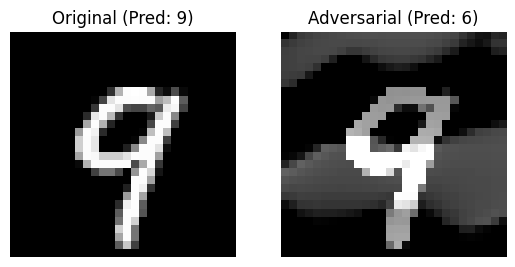

Found adversarial example for True=9, Target=8


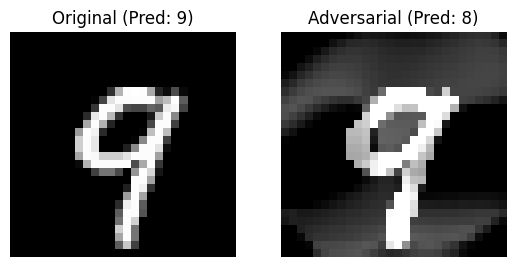

13
14
15
16
17
18
19
Found adversarial example for True=4, Target=7


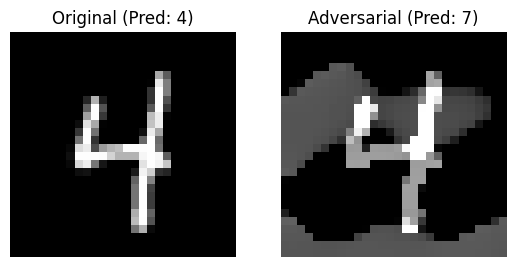

20
21
Found adversarial example for True=6, Target=9


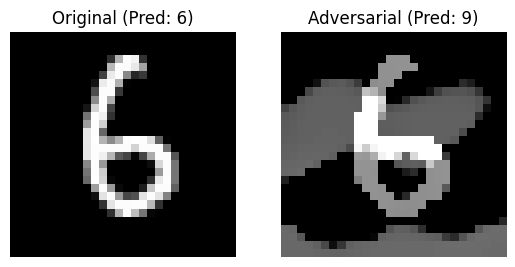

22
23
24
25
26
Found adversarial example for True=7, Target=4


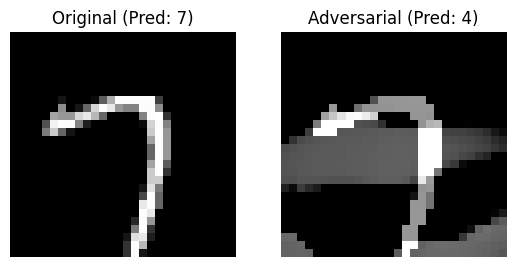

27
28
29
30
31
32
Found adversarial example for True=3, Target=0


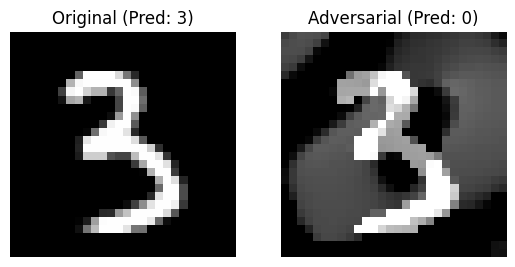

Found adversarial example for True=3, Target=2


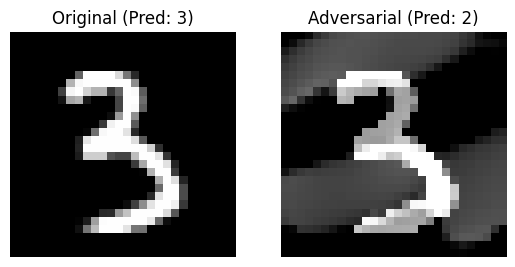

Found adversarial example for True=3, Target=7


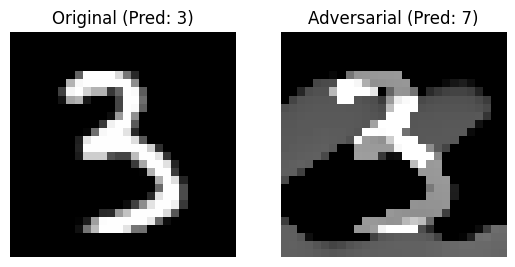

Found adversarial example for True=3, Target=9


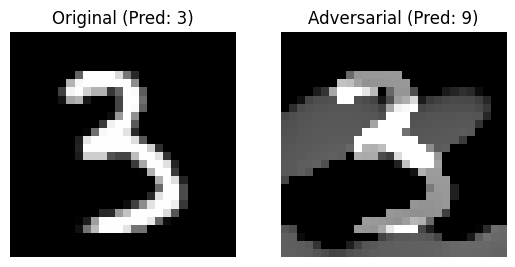

33
34
35
36
37
38
39
40
Found adversarial example for True=1, Target=5


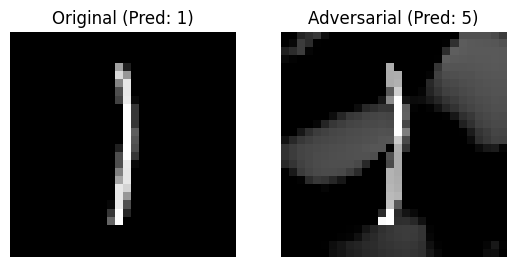

41
42
43
44
45
46
47
48
49
50
51
52
Found adversarial example for True=5, Target=0


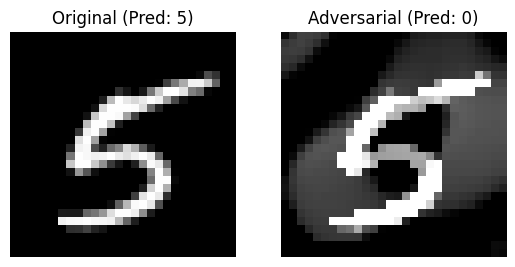

Found adversarial example for True=5, Target=2


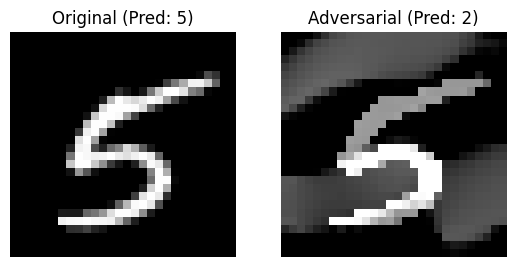

Found adversarial example for True=5, Target=3


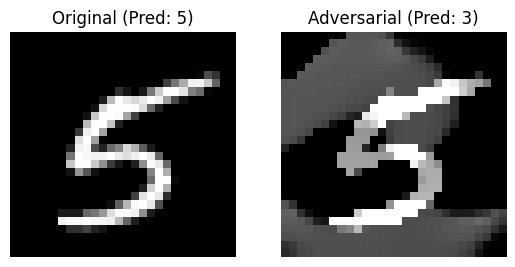

Found adversarial example for True=5, Target=4


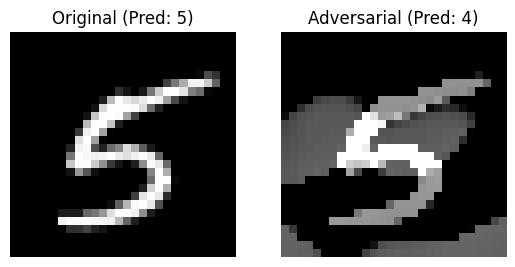

Found adversarial example for True=5, Target=6


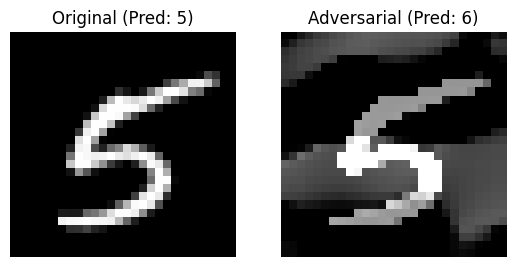

Found adversarial example for True=5, Target=9


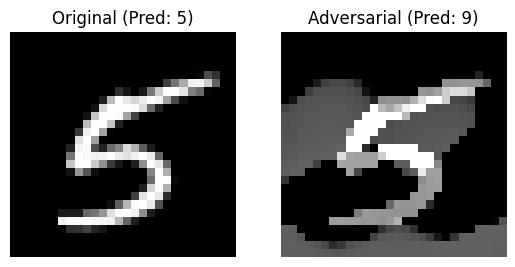

53
54
55
Found adversarial example for True=0, Target=2


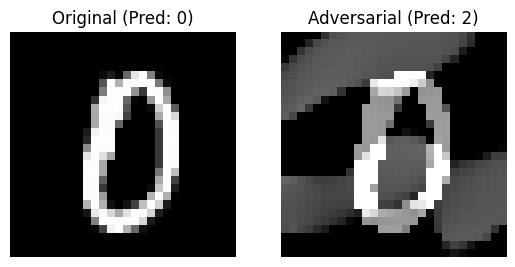

56
57
58
59
60
61
Found adversarial example for True=8, Target=0


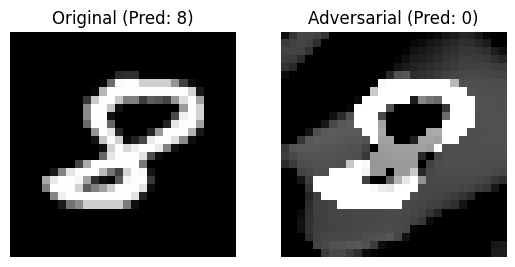

Found adversarial example for True=8, Target=2


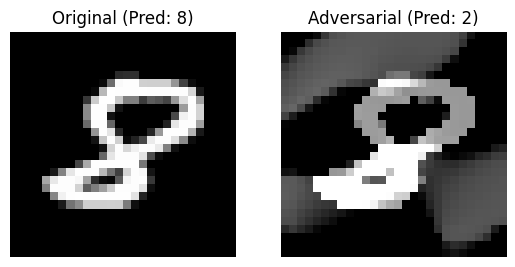

Found adversarial example for True=8, Target=3


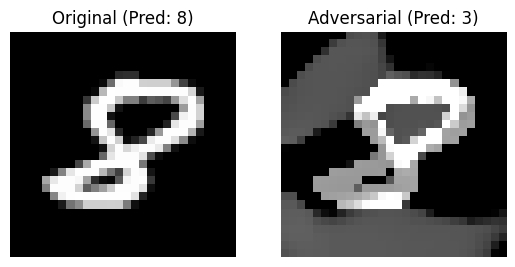

Found adversarial example for True=8, Target=4


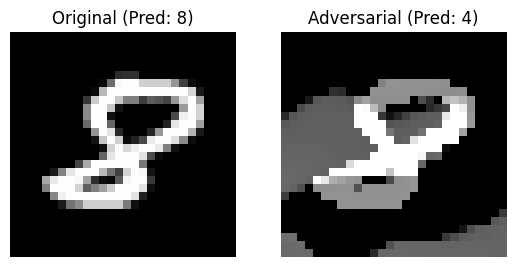

62
63
64
65
66
67
68
69
70
71
72
73
74
75
Found adversarial example for True=7, Target=6


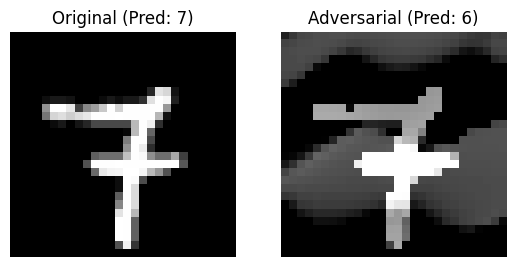

76
77
78
79
80
81
82
83
84
Found adversarial example for True=8, Target=9


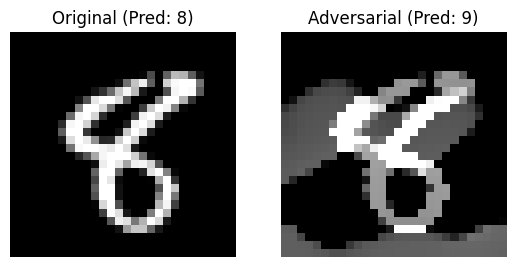

85
Found adversarial example for True=4, Target=8


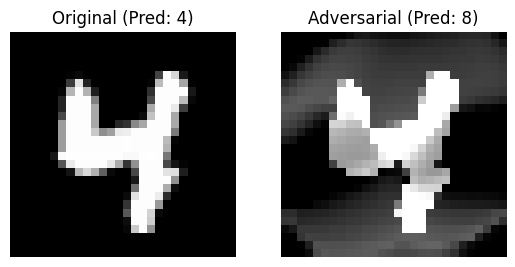

86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


In [26]:
suc_cnt_2, trial_cnt_2 = adversarial_on_testset(0.1)

<ipython-input-25-e9ffbd157a81>:1: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_1/trial_cnt_1


<Axes: >

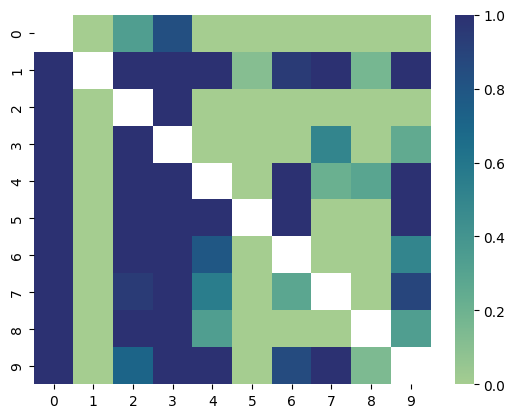

In [25]:
rates = suc_cnt_2/trial_cnt_2
sns.heatmap(rates,cmap="crest")

0
Found adversarial example for True=7, Target=0


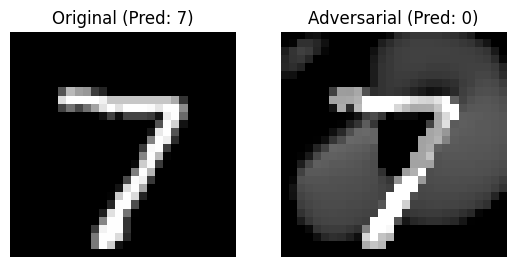

Found adversarial example for True=7, Target=2


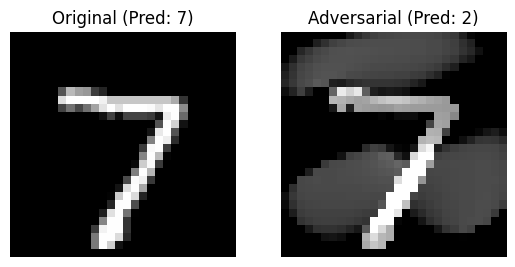

Found adversarial example for True=7, Target=3


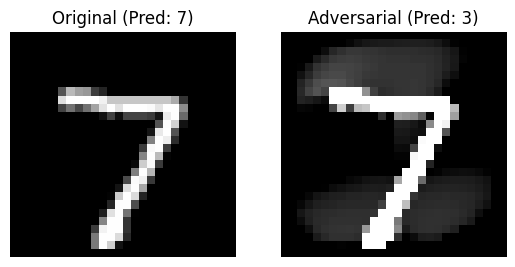

1
Found adversarial example for True=2, Target=0


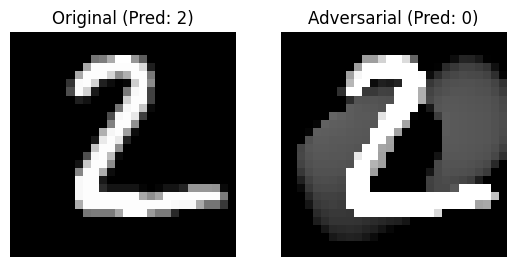

Found adversarial example for True=2, Target=3


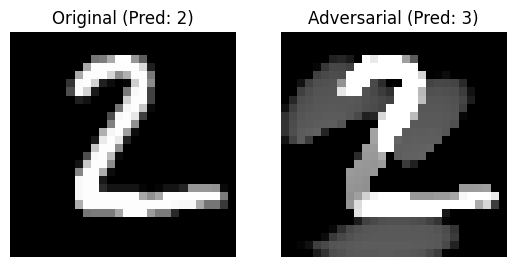

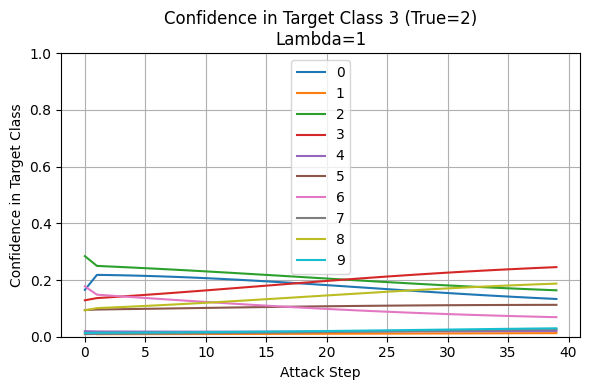

2
Found adversarial example for True=1, Target=0


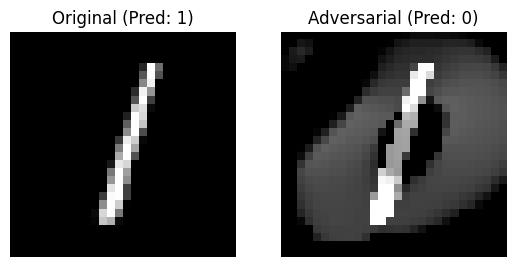

Found adversarial example for True=1, Target=2


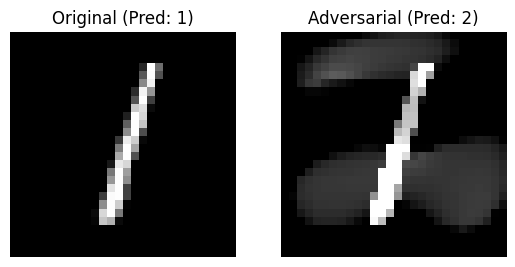

Found adversarial example for True=1, Target=3


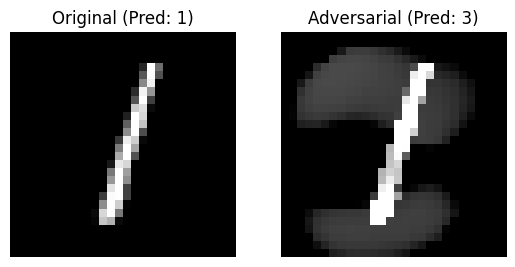

Found adversarial example for True=1, Target=4


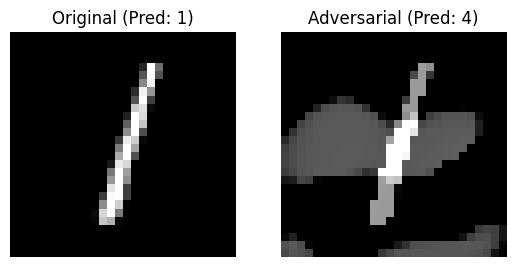

Found adversarial example for True=1, Target=6


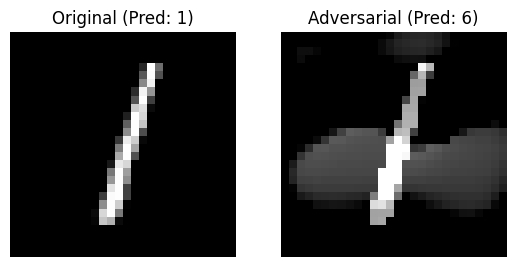

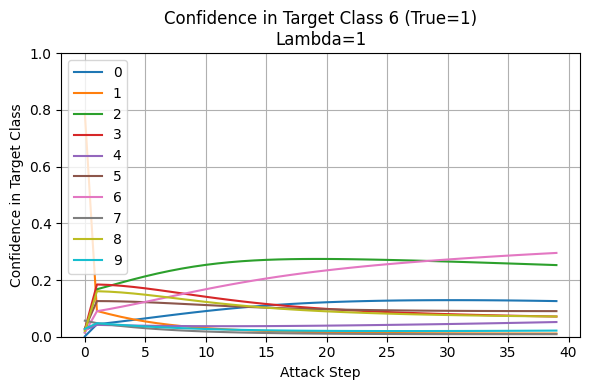

Found adversarial example for True=1, Target=7


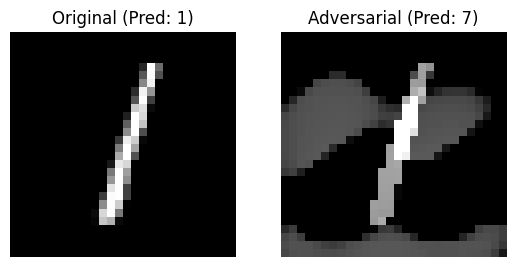

Found adversarial example for True=1, Target=9


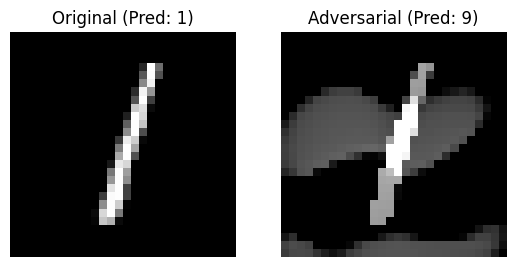

3
Found adversarial example for True=0, Target=3


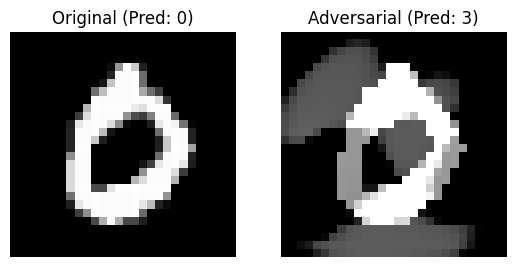

4
Found adversarial example for True=4, Target=0


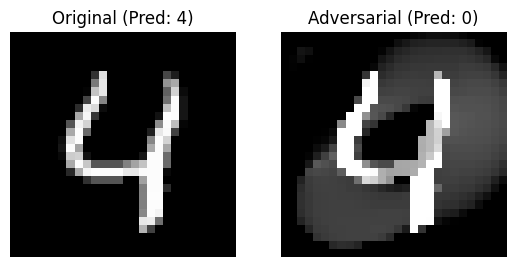

Found adversarial example for True=4, Target=2


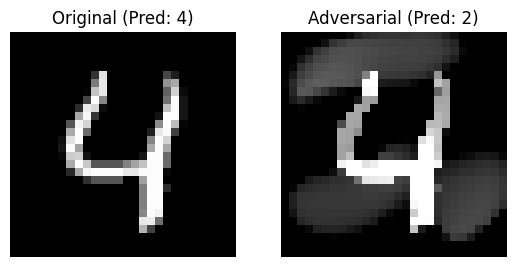

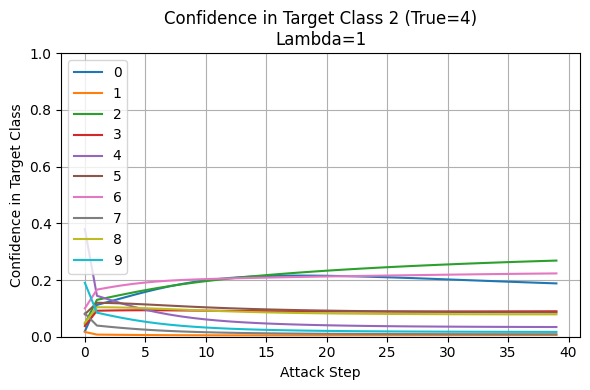

Found adversarial example for True=4, Target=3


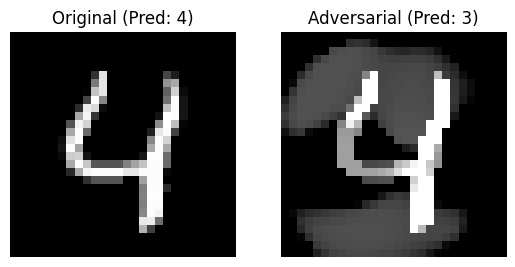

Found adversarial example for True=4, Target=6


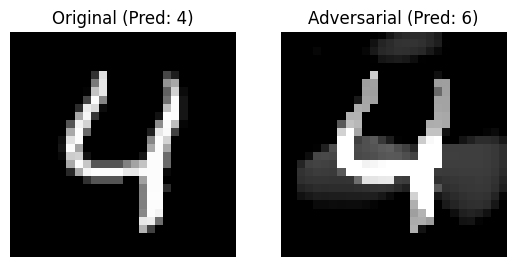

Found adversarial example for True=4, Target=9


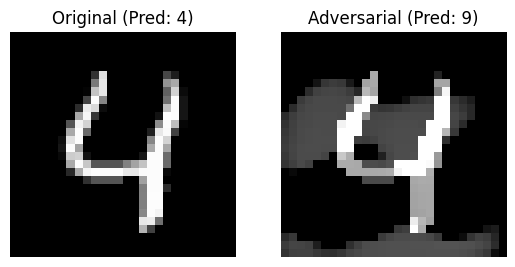

5
Found adversarial example for True=1, Target=8


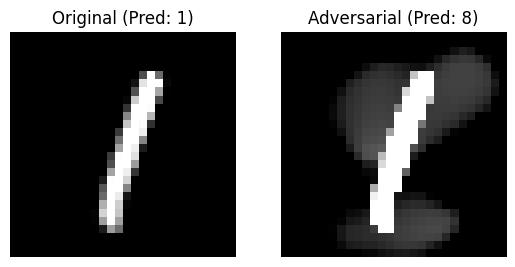

6
7
8
9
Found adversarial example for True=9, Target=0


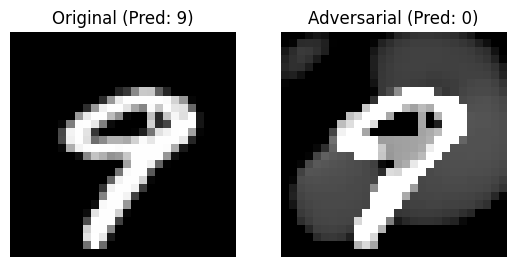

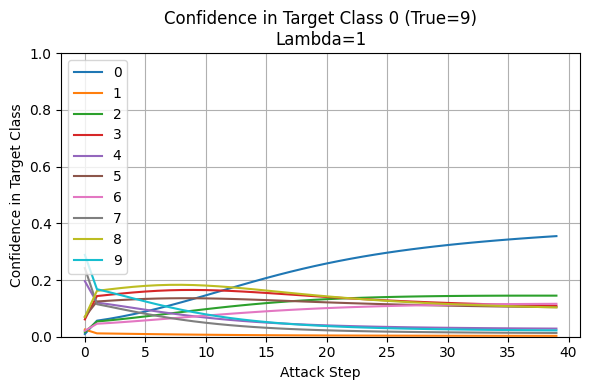

Found adversarial example for True=9, Target=3


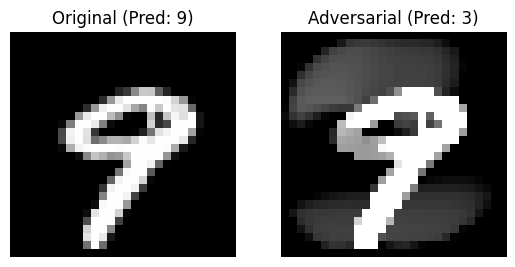

Found adversarial example for True=9, Target=4


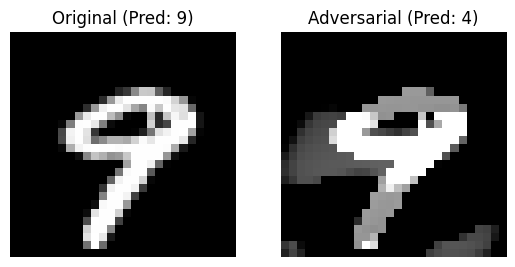

Found adversarial example for True=9, Target=7


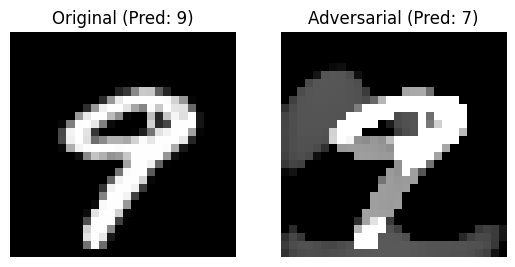

Found adversarial example for True=9, Target=8


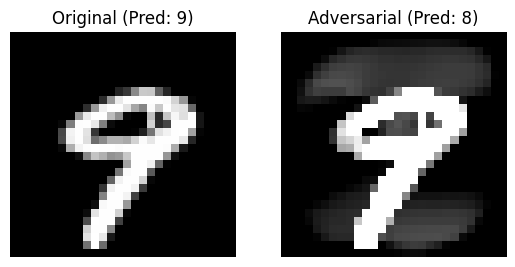

10
11
Found adversarial example for True=6, Target=0


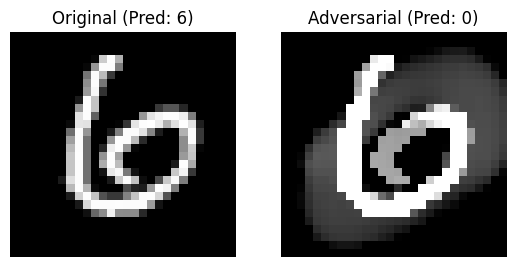

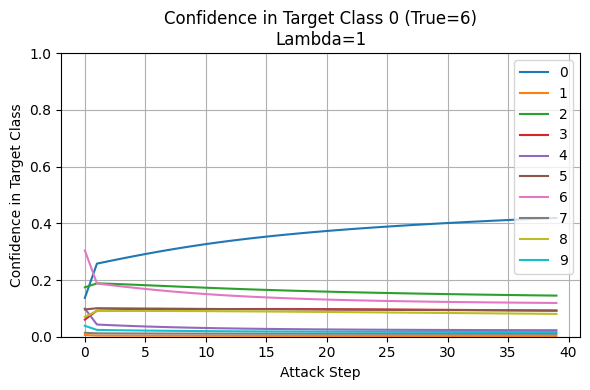

Found adversarial example for True=6, Target=2


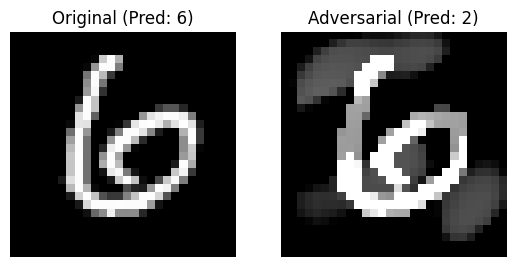

Found adversarial example for True=6, Target=3


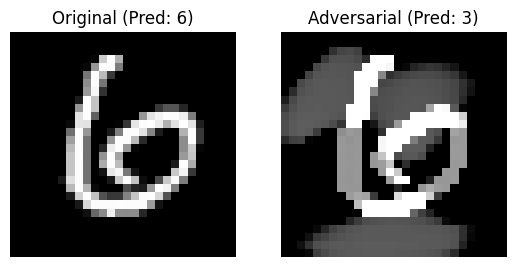

Found adversarial example for True=6, Target=4


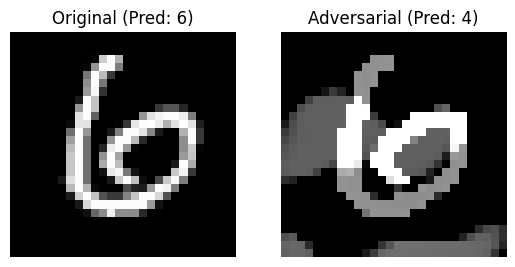

12
Found adversarial example for True=9, Target=2


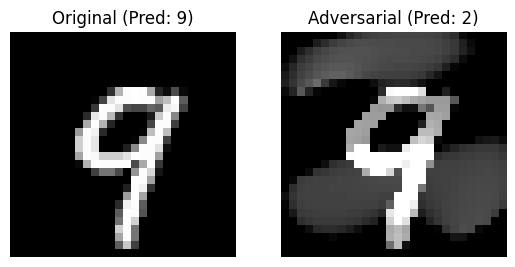

Found adversarial example for True=9, Target=6


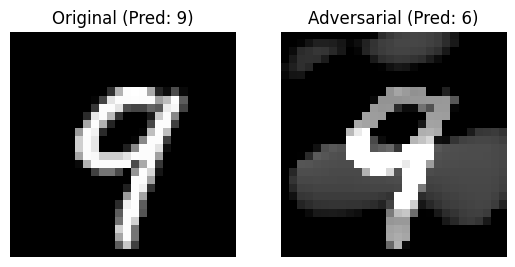

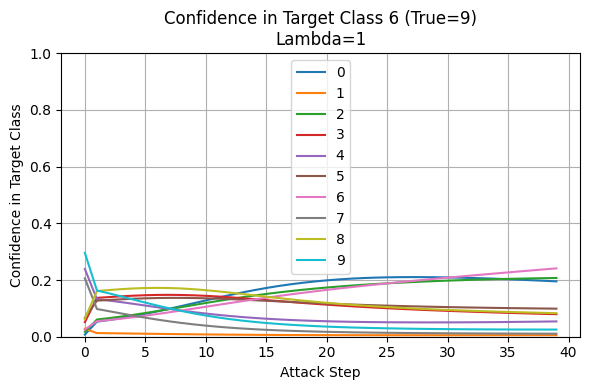

13
14
15
16
17
18
19
Found adversarial example for True=4, Target=7


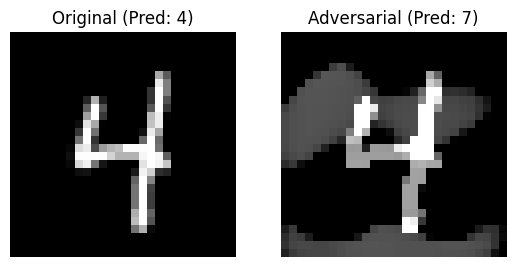

20
21
Found adversarial example for True=6, Target=9


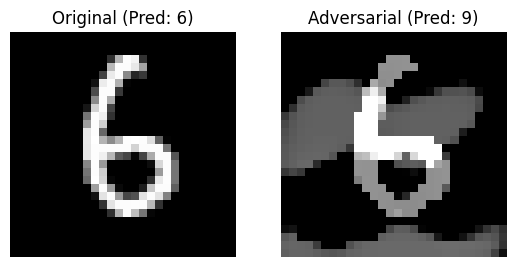

22
23
24
25
26
Found adversarial example for True=7, Target=4


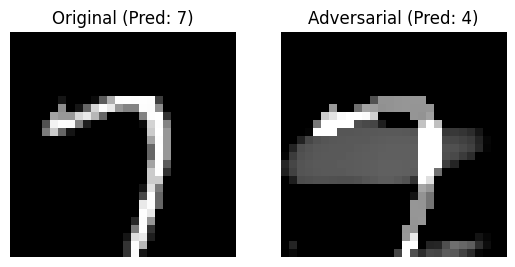

Found adversarial example for True=7, Target=9


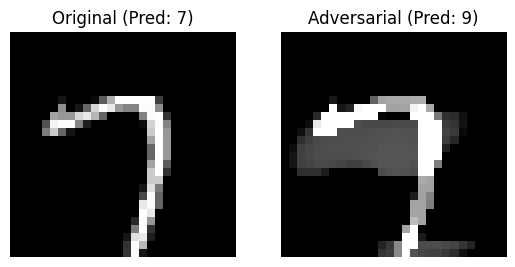

27
Found adversarial example for True=4, Target=8


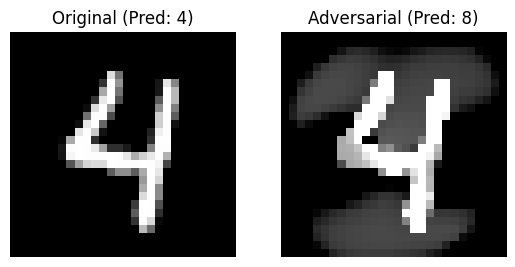

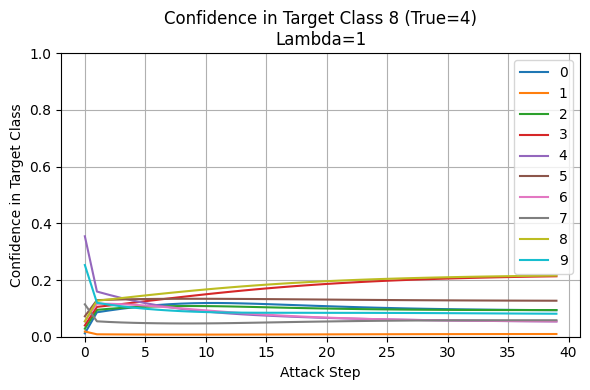

28
29
30
31
32
Found adversarial example for True=3, Target=0


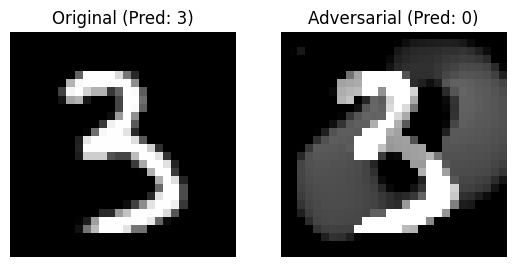

Found adversarial example for True=3, Target=2


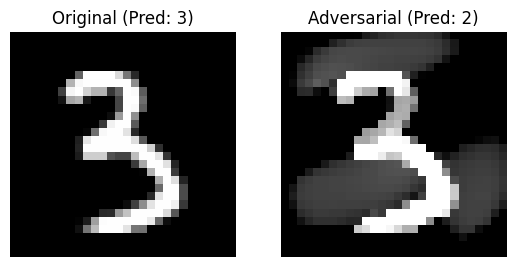

Found adversarial example for True=3, Target=7


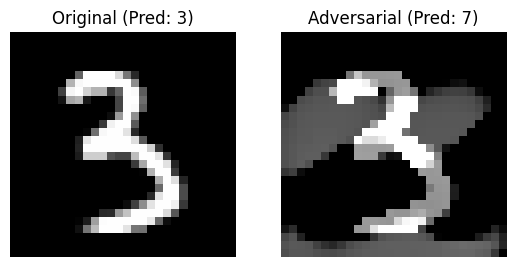

Found adversarial example for True=3, Target=9


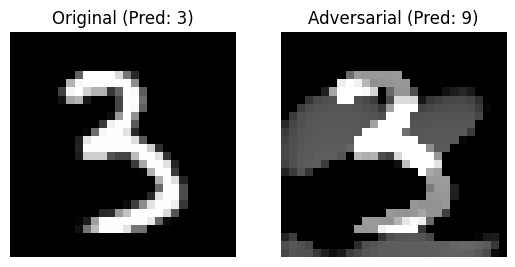

33
34
35
36
37
38
39
40
Found adversarial example for True=1, Target=5


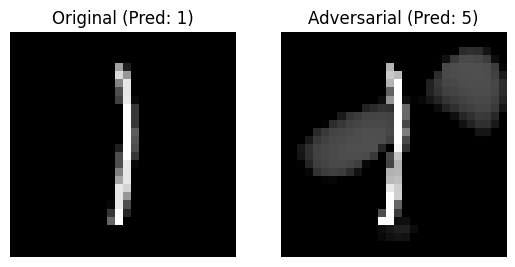

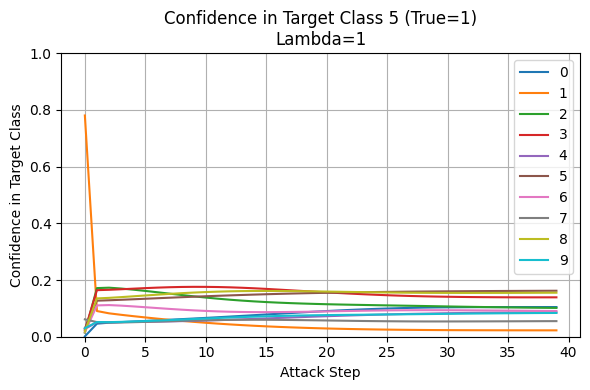

41
42
43
44
45
46
47
48
49
50
51
52
Found adversarial example for True=5, Target=0


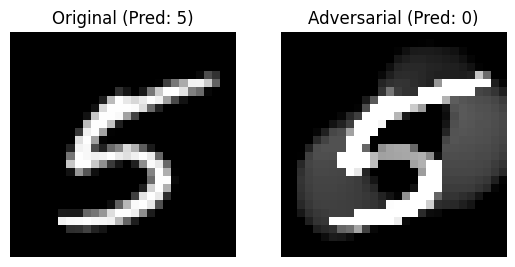

Found adversarial example for True=5, Target=2


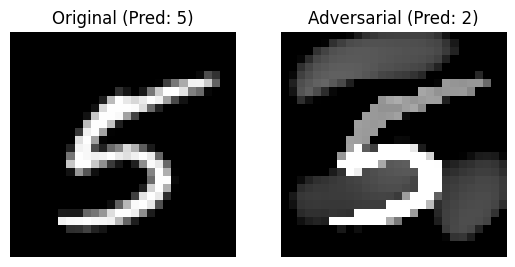

Found adversarial example for True=5, Target=3


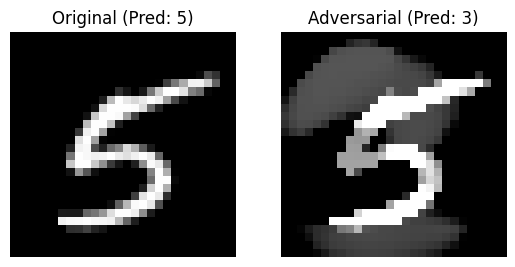

Found adversarial example for True=5, Target=4


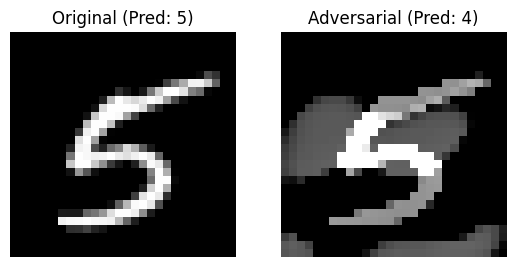

Found adversarial example for True=5, Target=9


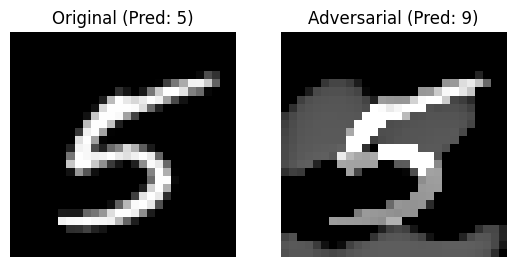

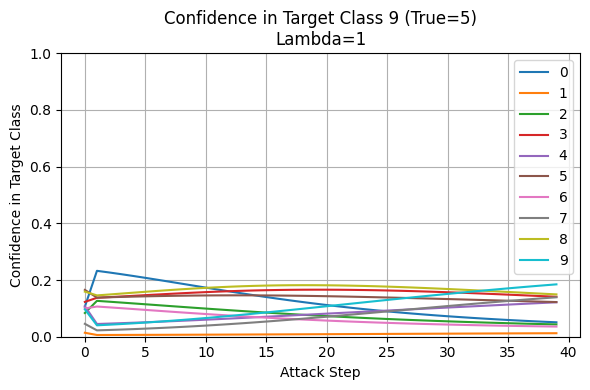

53
54
55
56
57
58
59
60
61
Found adversarial example for True=8, Target=0


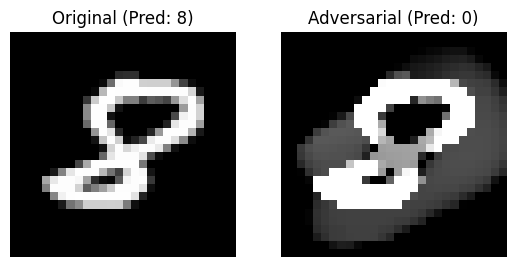

Found adversarial example for True=8, Target=2


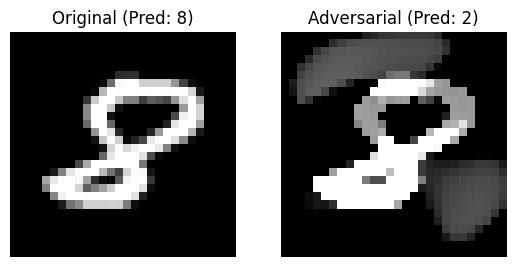

Found adversarial example for True=8, Target=3


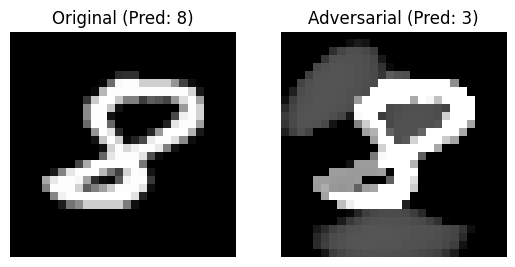

Found adversarial example for True=8, Target=4


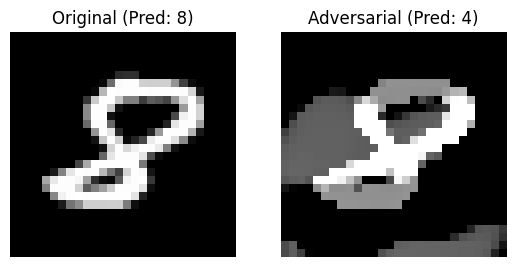

62
63
64
65
66
67
68
69
70
71
72
73
74
75
Found adversarial example for True=7, Target=6


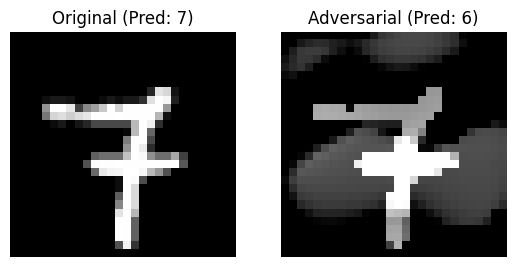

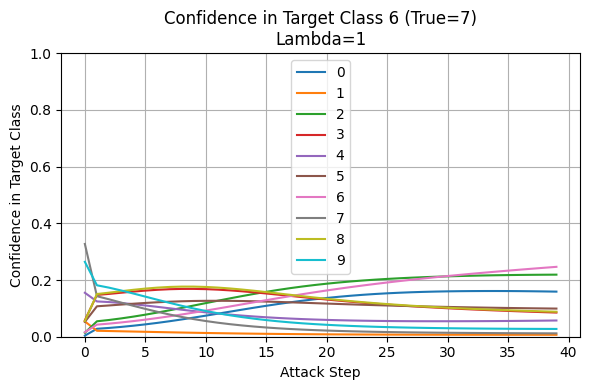

76
77
78
79
80
81
82
83
84
Found adversarial example for True=8, Target=9


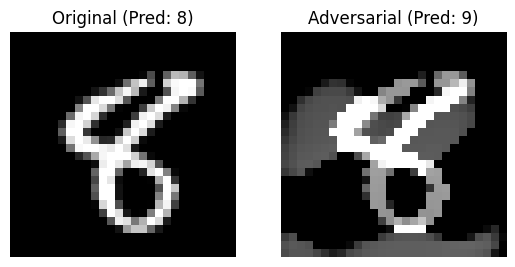

85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [31]:
suc_cnt_3, trial_cnt_3 = adversarial_on_testset(1)

<ipython-input-36-cb3963211996>:1: RuntimeWarning: invalid value encountered in divide
  rates = suc_cnt_3/trial_cnt_3


(array([[ 0,  0,  0,  6,  0,  0,  0,  0,  0,  0],
        [13,  0, 13, 13, 13,  1, 13, 13,  2, 13],
        [ 5,  0,  0,  5,  0,  0,  0,  0,  0,  0],
        [ 6,  0,  6,  0,  0,  0,  0,  2,  0,  1],
        [ 9,  0,  7,  9,  0,  0,  9,  2,  4,  9],
        [ 1,  0,  1,  1,  1,  0,  0,  0,  0,  1],
        [ 8,  0,  8,  8,  5,  0,  0,  0,  0,  3],
        [14,  0, 12, 14,  6,  0,  2,  0,  0, 10],
        [ 2,  0,  2,  2,  1,  0,  0,  0,  0,  1],
        [ 3,  0,  1,  3,  3,  0,  2,  2,  2,  0]]),
 array([[ 0,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [13,  0, 13, 13, 13, 13, 13, 13, 13, 13],
        [ 5,  5,  0,  5,  5,  5,  5,  5,  5,  5],
        [ 6,  6,  6,  0,  6,  6,  6,  6,  6,  6],
        [ 9,  9,  9,  9,  0,  9,  9,  9,  9,  9],
        [ 1,  1,  1,  1,  1,  0,  1,  1,  1,  1],
        [ 8,  8,  8,  8,  8,  8,  0,  8,  8,  8],
        [14, 14, 14, 14, 14, 14, 14,  0, 14, 14],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  0,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  0]

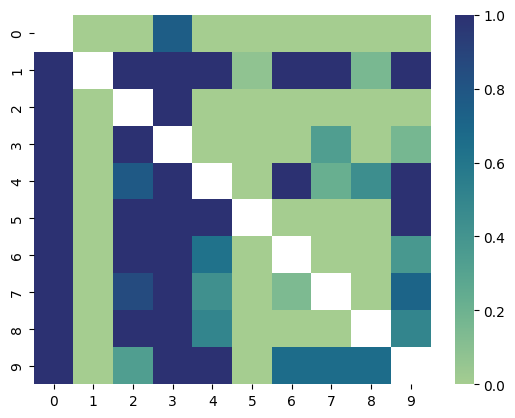

In [36]:
rates = suc_cnt_3/trial_cnt_3
sns.heatmap(rates,cmap="crest")
suc_cnt_3, trial_cnt_3

In [ ]:
suc_cnt_4, trial_cnt_4 = adversarial_on_testset(10)

In [ ]:
rates = suc_cnt_4/trial_cnt_4
sns.heatmap(rates,cmap="crest")